# Transformer Challenge

In [1]:
# We set the backend to TensorFlow. The code works with
# both `tensorflow` and `torch`. It does not work with JAX
# due to the behavior of `jax.numpy.tile` in a jit scope
# (used in `TransformerDecoder.get_causal_attention_mask()`:
# `tile` in JAX does not support a dynamic `reps` argument.
# You can make the code work in JAX by wrapping the
# inside of the `get_causal_attention_mask` method in
# a decorator to prevent jit compilation:
# `with jax.ensure_compile_time_eval():`.
from keras.layers import TextVectorization
from keras import ops
from keras import layers
import keras
import tensorflow.strings as tf_strings
import tensorflow.data as tf_data
import numpy as np
import re
import string
import random
import pathlib
import os
import pydash as py_

os.environ["KERAS_BACKEND"] = "tensorflow"

2025-03-22 21:30:33.350399: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 21:30:33.413977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742700633.446648  172389 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742700633.455032  172389 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 21:30:33.516491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Bajamos los datos de entrenamiento y validación. Definimos una carpeta donde guardarlos con el parámetro __cache_dir__, este paso nos ayuda a poder abrir el archivo en el siguiente paso, principalmente para el caso de WSL, donde las rutas están en raíces distintas.

In [2]:
path_downloads = "/mnt/c/Users/omarm/Downloads/"
save_models_dir = "/mnt/c/Users/omarm/Documents/Diplomado_IA/diplomado-ia-f/omarjh/models/"

In [3]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    cache_dir=path_downloads,
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng_extracted" / "spa-eng" / "spa.txt"

Abrimos el archivo descargado y se imprimen unas muestras de los pares de datos.

In [4]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

for _ in range(5):
    print(random.choice(text_pairs))

('Tom is the type of person who always smiles.', '[start] Tom es la clase de persona que siempre sonríe. [end]')
("You can't teach an old dog new tricks.", '[start] No se le puede enseñar nuevos trucos a un perro viejo. [end]')
('Mary bought a skirt and a blouse.', '[start] Mary compró una falda y una blusa. [end]')
('I need your assistance.', '[start] Necesito tu ayuda. [end]')
("Tom isn't playing tennis now.", '[start] Tom no está jugando al tenis ahora. [end]')


Se hace la separación de los pares en los conjuntos de entrenamiento, validación y prueba. Obteniendo que el total de datos es de 118964, para el conjunto de entrenamiento se usarán 83276, para el de validación 17844 y finalmente para el de prueba 17844.

In [5]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples: num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


Se limpian caracteres como puntuaciones o corchetes de los datos y se vectorizan los textos.

In [6]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 30
batch_size = 128


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

2025-03-22 21:30:37.659725: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Se crean los conjuntos de datos, con los textos ya vectorizados.

In [7]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(3915).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [8]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 30)
inputs["decoder_inputs"].shape: (128, 30)
targets.shape: (128, 30)


2025-03-22 21:30:39.073337: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
import keras.ops as ops


@keras.saving.register_keras_serializable()
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


@keras.saving.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


@keras.saving.register_keras_serializable()
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        inputs, encoder_outputs = inputs
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is None:
            inputs_padding_mask, encoder_outputs_padding_mask = None, None
        else:
            inputs_padding_mask, encoder_outputs_padding_mask = mask

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            query_mask=inputs_padding_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            query_mask=inputs_padding_mask,
            key_mask=encoder_outputs_padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [10]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(
    shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(
    shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(
    shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    decoder_outputs,
    name="transformer",
)

In [11]:
epochs = 3  # This should be at least 30 for convergence

transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,847,680 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,847,680 │ decoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 256) │  3,155,456 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, None)      │          0 │ decoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decoder │ (None, None, 256) │  5,259,520 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
│                     │                   │            │ not_equal_1[0][0… │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 256) │          0 │ transformer_deco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None,      │  3,855,000 │ dropout_3[0][0]   │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,965,336 (76.16 MB)

 Trainable params: 19,965,336 (76.16 MB)

 Non-trainable params: 0 (0.00 B)

Agregamos checkpoints para ir guardando el mejor modelo entrenado.

In [ ]:

transformer.compile(
    "rmsprop",
    loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),
    metrics=["accuracy"],
)

def scheduler(epoch, lr = 0.001):
    return lr/(epoch+1)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=save_models_dir + "translator.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    #keras.callbacks.LearningRateScheduler(scheduler)
    ]

transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

In [29]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = sequence_length
transformer: keras.Model = keras.models.load_model(
    save_models_dir + "translator.keras")

def decode_sequence(input_sentence, translator = transformer):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[
            :, :-1]
        predictions = translator(
            {
                "encoder_inputs": tokenized_input_sentence,
                "decoder_inputs": tokenized_target_sentence,
            }
        )

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for i in range(30, 40):
    input_sentence = test_pairs[i]
    eng_input = input_sentence[0]
    esp_input = input_sentence[1]
    translated = decode_sequence(eng_input, translator=transformer)
    print(
        f"Traducción de: {eng_input} ---> {translated.replace('[start]', '').replace('[end]', '')} | Traducción original: {esp_input.replace('[start]', '').replace('[end]', '')}")
    # print(translated)

Traducción de: Tom let me down. --->  tom quería joven  | Traducción original:  Tom me defraudó. 
Traducción de: What do you think this means? --->  qué gato que me [UNK]  | Traducción original:  ¿Qué crees que significa esto? 
Traducción de: I can show you the pictures. --->  puedo noche nombre la permite  | Traducción original:  Puedo mostrarte las fotos. 
Traducción de: "What's happening in the cave? I'm curious." "I have no idea." --->  verte en el caridad que estoy [UNK] de haber museo una necesitas  | Traducción original:  "¿Qué sucede dentro de la cueva? Tengo curiosidad." "No tengo idea." 
Traducción de: You're acting like an idiot. --->  quién se [UNK] en un interesado  | Traducción original:  Estás actuando como un idiota. 
Traducción de: I can't imagine life without him. --->  yo a el casar no lo [UNK]  | Traducción original:  No puedo imaginar la vida sin él. 
Traducción de: Some countries make voting compulsory. --->  el tus ojos en allá no [UNK]  | Traducción original:  A

#### Añadir embeddings pre-entrenados

Para añadir los embeddings pre-entrenados de Standford se realizarán algunas modificaciones a la clase PositionalEmbedding, añadiendo los datos pre-entrenados como una matriz de pesos.

In [ ]:
@keras.saving.register_keras_serializable()
class PositionalEmbeddingGlove(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, embed_weights = None, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            weights=embed_weights,
            trainable = True if embed_weights is None else False
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

Seleccionamos la dimensión de los embeddings más próxima a la que se estaba trabajando con el modelo previo, la cual era de 256, por esta razón se usarán los embeddings de longitud 200. Abrimos el archivo de texto y creamos un diccionario con la palabra como key y su vector de 200 valores como value.

In [21]:
glove_embed_dim = 200
glove_path = path_downloads + f"glove.6B/glove.6B.{glove_embed_dim}d.txt"

embeddings_dict = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        word, values = line.split(maxsplit=1)
        coefs = np.fromstring(values, dtype="float32", sep=' ')
        embeddings_dict[word] = coefs
    f.close()

print(
    f"Vocabulario pre-entrenado con un total de {len(embeddings_dict)} palabras.")

Vocabulario pre-entrenado con un total de 400000 palabras.


Con el diccionario de embeddings pre-entrenados buscamos cuales de las palabras de nuestro vocabulario de 15000 palabras en español aparecen en el, obteniendo que se hallaron 4662 palabras del vocabulario de español en los embeddings pre-entreados de Stanford. Algunas de ellas son 

    ['quemada', 'qomolangma', 'python', 'puzzle', 'pus', 'pureza', 'pulse', 'pullover', 'pueblos', 'publicar'].

Algunas palabras no encontradas son 

    ['puntuación', 'puntiagudos', 'pulsas', 'pulgadas', 'puercos', 'pudín', 'publicará', 'publicaron', 'publicamos', 'psíquica']

Las palabras del vocabulario que si se encuentran en el conjunto de palabras pre-entrenadas se usan para crear la matriz de embeddings que se usaran como pesos durante el entrenamiento del siguiente modelo usando los embeddings de Standford.

In [22]:

spa_vocab = spa_vectorization.get_vocabulary()
vocab_size = len(spa_vocab)  # Número de palabras en el vocabulario
embedding_matrix = np.zeros((vocab_size, glove_embed_dim))

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")


def custom_standardization(input_string: str):
    lowercase = input_string.lower()
    return lowercase.replace("[%s]" % re.escape(strip_chars), "")

no_found_words = []
found_words = []
for i, word_np in enumerate(spa_vocab):
    word = custom_standardization(word_np)
    embedding_values = py_.get(embeddings_dict, word)
    if embedding_values is not None:
        found_words.append(word)
        embedding_matrix[i] = embedding_values  # Usar embedding preentrenado
        continue
    no_found_words.append(word)

print(f"Se hallaron {len(found_words)} palabras del vocabulario de español en los embeddings pre-entreados de stanford. Algunas de ellas son {found_words[-10:]}")
print(f"Algunas palabras no encontradas son {no_found_words[-10:]}")

Se hallaron 4662 palabras del vocabulario de español en los embeddings pre-entreados de stanford. Algunas de ellas son ['quemada', 'qomolangma', 'python', 'puzzle', 'pus', 'pureza', 'pulse', 'pullover', 'pueblos', 'publicar']
Algunas palabras no encontradas son ['puntuación', 'puntiagudos', 'pulsas', 'pulgadas', 'puercos', 'pudín', 'publicará', 'publicaron', 'publicamos', 'psíquica']


In [23]:
embedding_matrix.shape

(15000, 200)

In [ ]:
embed_dim = glove_embed_dim
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(
    shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbeddingGlove(sequence_length, vocab_size, embed_dim,
                             embed_weights=embedding_matrix)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(
    shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(
    shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbeddingGlove(sequence_length, vocab_size, embed_dim,
                             embed_weights=embedding_matrix)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

transformerGlove = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    decoder_outputs,
    name="transformerGlove",
)

epochs = 3  # This should be at least 30 for convergence

transformerGlove.summary()

Model: "transformerGlove"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 200) │  3,006,000 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_22        │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 200) │  3,006,000 │ decoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 200) │  2,107,248 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal_22[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_23        │ (None, None)      │          0 │ decoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 200) │  3,392,648 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
│                     │                   │            │ not_equal_23[0][… │
│                     │                   │            │ not_equal_22[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, None, 200) │          0 │ transformer_deco… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, None,      │  3,015,000 │ dropout_41[0][0]  │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,526,896 (55.42 MB)

 Trainable params: 8,526,896 (32.53 MB)

 Non-trainable params: 6,000,000 (22.89 MB)

In [ ]:
transformerGlove.compile(
    "Adam",
    loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),
    metrics=["accuracy"],
)


def scheduler(epoch, lr=0.001):
    return lr/(epoch+1)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=save_models_dir + "translatorGlove.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    # keras.callbacks.LearningRateScheduler(scheduler)
]

transformerGlove.fit(train_ds, epochs=epochs,
                validation_data=val_ds, callbacks=callbacks)

In [30]:
transformerGlove: keras.Model = keras.models.load_model(
    save_models_dir + "translatorGlove.keras")

test_eng_texts = [pair[0] for pair in test_pairs]
for i in range(30, 40):
    input_sentence = test_pairs[i]
    eng_input = input_sentence[0]
    esp_input = input_sentence[1]
    translated = decode_sequence(eng_input, translator=transformerGlove)
    print(
        f"Traducción de: {eng_input} ---> {translated.replace('[start]', '').replace('[end]', '')} | Traducción original: {esp_input.replace('[start]', '').replace('[end]', '')}")
    # print(translated)

Traducción de: Tom let me down. --->  tom me viviendo  | Traducción original:  Tom me defraudó. 
Traducción de: What do you think this means? --->  qué errores que está cerrada  | Traducción original:  ¿Qué crees que significa esto? 
Traducción de: I can show you the pictures. --->  te poco a la lugar  | Traducción original:  Puedo mostrarte las fotos. 
Traducción de: "What's happening in the cave? I'm curious." "I have no idea." --->  qué ha en el contar no puedo oír este toda  | Traducción original:  "¿Qué sucede dentro de la cueva? Tengo curiosidad." "No tengo idea." 
Traducción de: You're acting like an idiot. --->  me tiempo espero un encuentra  | Traducción original:  Estás actuando como un idiota. 
Traducción de: I can't imagine life without him. --->  días de cinco lo pasatiempo  | Traducción original:  No puedo imaginar la vida sin él. 
Traducción de: Some countries make voting compulsory. --->  ese se [UNK] el solas  | Traducción original:  Algunos países hacen obligatorio vo

# Transformer Challenge for 3/22/2025

    1.	Get the the notebook from https://keras.io/examples/nlp/neural_machine_translation_with_transformer/
    2.	Make it run. Note that it uses the spa-eng file from the Anki site
    3.	Include code to save the model on disk so that you can use the pre-trained model
    4.	Include code to use the pre-trained embeddings from Stanford.
            a.	Link at https://nlp.stanford.edu/projects/glove/
    5.	Include code to show the layer activations as the ones shown the notebook that shown during the lecture.
            a.	Code at https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb
    6.	Work with the model to improve its performance. Things to try are:
        a.	Use more than 30 epochs
        b.	Change the number of ngrams
        c.	Change the learning rate
        d.	Change the optimizer
        e.	Change the metric
        f.	Explore how to use the BLUE (Bilingual Evaluation Understudy)
        g.	Explore how to use the Rouge  score
    7.	OPTIONAL: Get and run the code from https://keras.io/examples/nlp/neural_machine_translation_with_keras_hub/
        a.	to use the Rouge metric
    8.	Write a short report (5 pages) describing your work, results, comments
    9.	Deadline: 03/22/2025 @ Noon, CDMX Time, using the Github page :
    10.	https://github.com/camachojua/diplomado-ia/tree/main/python/src/student_submissions/Transform   er

## Metodología (1,2, 3)
Se bajaron los datos de entrenamiento y validación. Definimos una carpeta donde guardarlos con el parámetro __cache_dir__, este paso nos ayuda a poder abrir el archivo en el siguiente paso, principalmente para el caso de WSL, donde las rutas están en raíces distintas.

```python
path_downloads = "/mnt/c/Users/omarm/Downloads/"
save_models_dir = "/mnt/c/Users/omarm/Documents/Diplomado_IA/diplomado-ia-f/omarjh/models/"
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    cache_dir=path_downloads,
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
```

Abrimos el archivo descargado y se imprimen unas muestras de los pares de datos.
```python
('Tom is the type of person who always smiles.', '[start] Tom es la clase de persona que siempre sonríe. [end]')
("You can't teach an old dog new tricks.", '[start] No se le puede enseñar nuevos trucos a un perro viejo. [end]')
('Mary bought a skirt and a blouse.', '[start] Mary compró una falda y una blusa. [end]')
('I need your assistance.', '[start] Necesito tu ayuda. [end]')
("Tom isn't playing tennis now.", '[start] Tom no está jugando al tenis ahora. [end]')
```
Se hace la separación de los pares en los conjuntos de entrenamiento, validación y prueba. Obteniendo que el total de datos es de __118964__, para el conjunto de entrenamiento se usarán __83276__, para el de validación __17844__ y finalmente para el de prueba __17844__.
Se limpian caracteres como puntuaciones o corchetes de los datos y se vectorizan los textos.
Se crean los conjuntos de datos, con los textos ya vectorizados.
Con las clases definidas para crear el modelo, obtenemos la siguiente arquitectura:

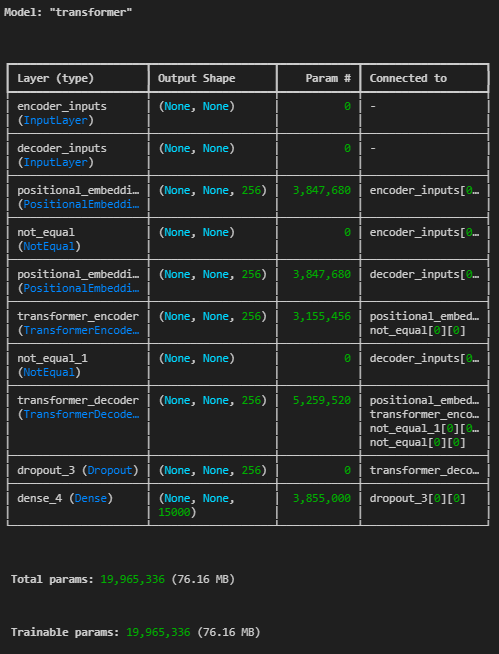

Agregamos checkpoints para ir guardando el mejor modelo entrenado.

```python
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=save_models_dir + "translator.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    #keras.callbacks.LearningRateScheduler(scheduler)
    ]
```

## Añadir embeddings pre-entrenados (4)

Para añadir los embeddings pre-entrenados de Standford se realizaron algunas modificaciones a la clase PositionalEmbedding, añadiendo los datos pre-entrenados como una matriz de pesos.
```python
self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, 
            output_dim=embed_dim,
            weights=embed_weights,
            trainable = True if embed_weights is None else False
        )
```

Seleccionamos la dimensión de los embeddings más próxima a la que se estaba trabajando con el modelo previo, la cual era de 256, por esta razón se usarán los embeddings de longitud 200. Abrimos el archivo de texto y creamos un diccionario con la palabra como key y su vector de 200 valores como value, este diccionario contiene 400 mil palabras en distintos idiomas.

Con el diccionario de embeddings pre-entrenados buscamos cuales de las palabras de nuestro vocabulario de __15000__ palabras en español aparecen en el, obteniendo que se hallaron __4662__ palabras del vocabulario de español en los embeddings pre-entreados de Stanford. Algunas de ellas son 

    ['quemada', 'qomolangma', 'python', 'puzzle', 'pus', 'pureza', 'pulse', 'pullover', 'pueblos', 'publicar'].

Algunas palabras no encontradas son 

    ['puntuación', 'puntiagudos', 'pulsas', 'pulgadas', 'puercos', 'pudín', 'publicará', 'publicaron', 'publicamos', 'psíquica']

Las palabras del vocabulario que si se encuentran en el conjunto de palabras pre-entrenadas se usan para crear la matriz de embeddings que se usaran como pesos durante el entrenamiento del siguiente modelo usando los embeddings de Standford.

Generamos el nuevo modelo incluyendo los embeddings pre-entrenados, se obtuvo la siguiente arquitectura:

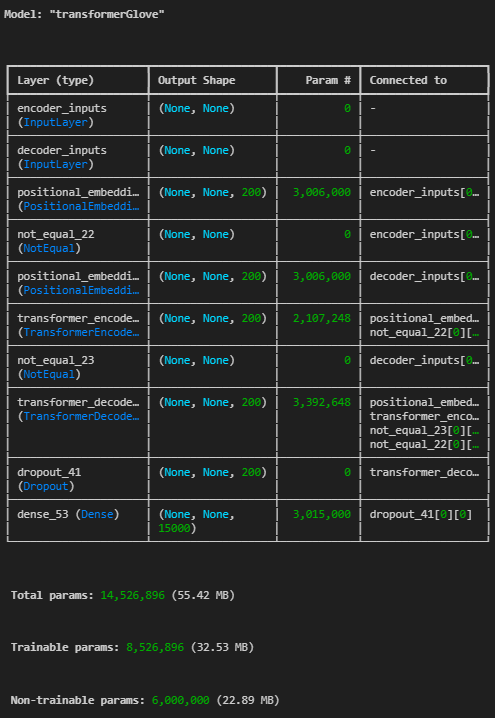

## Resultados y conclusiones (6)

Tras el entrenamiento del primer modelo, se obtuvo una exactitud baja de alrededor del 15%, para el segundo modelo esta exactitud creció levemente llegando alrededor del 20%. Se tiene que aclarar que la cantidad de épocas usadas fueron solamente 10 debido al tiempo de ejecución muy prolongado con el equipo usado, este factor es muy mejorable pues el comportamiento de los modelos mostraba un creciente aumento en la exactitud y una disminución en el valor de la perdida, por lo cual el continuar con más épocas seguramente nos daría un mejor resultado.
Otro factor que mejoro levemente la exactitud obtenida fue cambiar el optimizador "rmsprop" por "Adam". Se probaron otros cambios como aumentar la máxima longitud de las oraciones para entrenamiento, pero debido a la falta de épocas no es posible concluir si este cambio fue productivo o no. 
El cambiar el learning rate también influyó, usar un learning rate mayor condujo a peores tasas de actualización de la exactitud, cerrando incluso por debajo del 10% para un lr de 0.01, por lo cual el mejor valor continuo siendo el default de 0.001.

Como conclusión se observó una leve mejora en la exactitud del modelo al incluir los embeddings pre-entrenados de Standford, sin embargo el aumento no fue muy significativo, esto se atribuye principalmente a dos factores, el primero es la cantidad de palabras del vocabulario que si se encontraban en los datos pre-entrenados, al ser solamente 4662 de 15 mil, estamos hablando de que menos de un tercio de las palabras de nuestro vocabulario usado para entrenar y probar el modelo cuentan con un valor pre-entrenado, por lo cual aún la mayoría de palabras continua siendo entrenadas desde cero. Algo que quizá podría funcionar seria cambiar el parámetro "trainable" de los embeddings a siempre True, esto con el objetivo de, si partir de una base entrenada para algunas palabras, pero aun asi buscar un nuevo entrenamiento pues la mayoría de ellas no cuenta con un precedente.
El segundo punto a considerar fue en este caso en particular la falta de épocas de entrenamiento para lograr determinar de mejor manera la evolución de los modelos.

## Comentarios

El ejercicio resulto bastante interesante, también sirvió para notar la necesidad de una capacidad de cómputo mayor, pues para estos modelos los tiempos de entrenamiento fueron bastante mayores a los de ejercicios previos y esto llegó a ser una limitante para el correcto análisis de los modelos finales, por lo cual me deja en claro que debo tomar acciones para remediar esta situación para trabajos futuros.

Con el uso de los embeddings pre-entrenados de Standford pude aprender que, aunque un conjunto de datos parezca bastante extenso, esto no siempre es así, ya que del total de datos solamente una pequeña parte de ellos (alrededor del 1%-2%) fueron de utilidad para nuestro caso de uso. Fue una valiosa lección de la importancia de contar con un buen conjunto de datos y sobre todo que sean de utilidad para el proyecto en el que se esté trabajando, pues a primera vista podemos llevarnos una impresión errónea.
